# Face Landmarks

Using a subset of [UMD Faces](http://umdfaces.io) database to train a face landmarks predicting model.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import random
import sys

In [3]:
try:
    old_path
except NameError:
    old_path = sys.path
    new_path = [str(Path.cwd()/'loop')] + old_path
    sys.path = new_path

In [4]:
from ipyexperiments import IPyExperimentsPytorch
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision import models
from torchvision.transforms.functional import to_tensor, normalize

In [6]:
from loop.torch_helpers.modules import FineTunedModel, AdaptiveConcatPool2d, Flatten, classname
from basedir import DATA, META, use_simple, get_train_folder, get_num_landmarks
from plot import show, show_random_grid
from utils import split, IMAGENET_STATS
from dataset import FaceLandmarks
from metrics import rmse_loss
from transform import MatrixAugmentation, AdjustGamma, CropResizeFace, ToXY

/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [7]:
SEED = 1
DEVICE = torch.device('cuda:1')
use_simple(False)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

---
## Reading Cropped Images

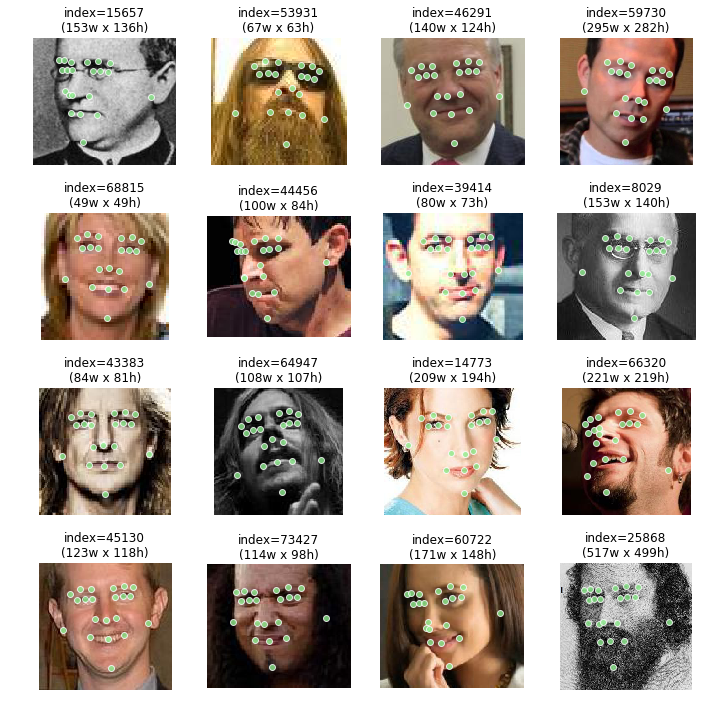

In [8]:
show_random_grid(get_train_folder())

Ok, it seems that each sample includes (at least) one human in various poses with various backgrounds. Therefore, our first goal is to convert this dataset into a more suitable format before we processed with training the model. The most straightforward way to do so is to _crop_ the faces only and save them into smaller files.

## Data Preparation

In [9]:
import ignite
from ignite import engine as E
from ignite.metrics import Loss
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler

In [10]:
def create_dataset_item(info, root):
    """Creates a dictionary with face and landmarks coordinates from data frame record."""
    
    return {
        'subject_id': info.subject_id,
        'image_path': str(root/info.file),
        'x_pos': [info[k] for k in info.keys() if k[0] == 'p' and k[-1] == 'x'],
        'y_pos': [info[k] for k in info.keys() if k[0] == 'p' and k[-1] == 'y'],
        'face': (info.face_x, info.face_y, info.face_width, info.face_height)}

In [11]:
meta = pd.read_csv(META)
meta.columns = meta.columns.str.lower()
items = [create_dataset_item(record, DATA) for _, record in meta.iterrows()]
trn_idx, val_idx = train_test_split(np.arange(len(items)), test_size=0.1, random_state=SEED)
train = np.array(items)[trn_idx].tolist()
valid = np.array(items)[val_idx].tolist()

In [ ]:
trn_ds = FaceLandmarks(
    items=train, 
    transforms=[
        MatrixAugmentation([
            {'name': 'rotation', 'angle': 10},
            {'name': 'mirror'},
            {'name': 'perspective', 'percentage': (0.075, 0.012)}
        ]),
        CropResizeFace(pad=0.15),
        AdjustGamma(min_gamma=0.7)
    ], 
    to_tensors=ToXY(IMAGENET_STATS))

val_ds = FaceLandmarks(
    items=valid, 
    transforms=[CropResizeFace(pad=0.15)], 
    to_tensors=ToXY(IMAGENET_STATS))

In [ ]:
trn_ds.show_random_grid(5, transformed=True)

In [ ]:
def create_data_loaders(train_data, valid_data, bs=512, num_workers=0):
    train_loader = DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_data, batch_size=bs, shuffle=False, num_workers=num_workers)
    return train_loader, valid_loader

In [ ]:
trn_dl, val_dl = create_data_loaders(trn_ds, val_ds, bs=300, num_workers=12)

In [ ]:
def conv(ni, no, kernel, stride, groups=1, lrn=False, bn=False, pool=None, activ='prelu'):
    layers = [nn.Conv2d(ni, no, kernel, stride, groups=groups)]
    activation = {
        'relu': nn.ReLU(inplace=True),
        'leaky_relu': nn.LeakyReLU(inplace=True),
        'prelu': nn.PReLU(),
        'linear': None
    }[activ]
    if activation is not None:
        layers += [nn.PReLU()]
    if lrn:
        layers.append(nn.LocalResponseNorm(2))
    elif bn:
        layers.append(nn.BatchNorm2d(no))
    if pool is not None:
        layers.append(nn.MaxPool2d(*pool))
    return layers

In [ ]:
def fc(ni, no, bn=True, activ='linear', dropout=None):
    layers = [nn.Linear(ni, no)]
    if bn:
        layers.append(nn.BatchNorm1d(no))
    if activ is not None:
        activation = {
            'relu': nn.ReLU(inplace=True),
            'prelu': nn.PReLU(),
            'linear': None
        }[activ]
        if activation is not None:
            layers.append(activation)
    if dropout is not None:
        layers.append(nn.Dropout(dropout))
    return layers

In [ ]:
class LandmarksRegressor(nn.Module):
    def __init__(self, n=get_num_landmarks(), top=None):
        super().__init__()
        layers  = conv(  3,  16, 3, 1, bn=True, activ='leaky_relu', pool=(2, 2))
        layers += conv( 16,  32, 3, 1, bn=True, activ='leaky_relu', pool=(2, 2)) 
        layers += conv( 32,  64, 3, 1, bn=True, activ='leaky_relu', pool=(2, 2))
        layers += conv( 64, 128, 3, 1, bn=True, activ='leaky_relu', pool=(2, 2))
        layers += conv(128, 256, 3, 1, bn=True, activ='leaky_relu', pool=(2, 2))
        layers += [AdaptiveConcatPool2d(1), Flatten()]
        layers += fc(512, 500, activ='relu')
        layers += fc(500, 500, activ='relu')
        layers += fc(500, 500, activ='relu')
        layers += fc(500, 500, activ='relu')
        layers += fc(500, 500, activ='relu')
        layers += fc(500, n)
        if top is not None:
            layers.append(top)
        self.model = nn.Sequential(*layers)
        self.model.apply(self.init)
        
    def forward(self, x):
        breakpoint()
        return self.model(x)
    
    def init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            nn.init.zeros_(m.bias)
        elif classname(m).startswith('BatchNorm'):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 1e-3)

In [ ]:
reg = LandmarksRegressor()
opt = optim.SGD(reg.parameters(), lr=1e-2, momentum=0.5)
loss = F.l1_loss
trainer = E.create_supervised_trainer(reg, opt, loss, device=DEVICE)
evaluator = E.create_supervised_evaluator(reg, device=DEVICE, metrics={'rmse': Loss(loss)})

In [ ]:
log_interval = int(len(trn_dl) * 0.2)
desc = "Iteartion {:03d} loss: {:.4f}"

In [ ]:
sched = CosineAnnealingScheduler(opt, 'lr', 1e-1, 1e-3, len(trn_dl))
trainer.add_event_handler(E.Events.ITERATION_COMPLETED, sched)

@trainer.on(E.Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    it = (engine.state.iteration - 1) % len(trn_dl) + 1
    if it % log_interval == 0:
        print(desc.format(it, engine.state.output))

@trainer.on(E.Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(trn_dl)
    metrics = evaluator.state.metrics
    avg_loss = metrics['rmse']
    print('Training Results - Epoch: {} Avg loss {:.2f}'
          .format(engine.state.epoch, avg_loss))
    
@trainer.on(E.Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_dl)
    metrics = evaluator.state.metrics
    avg_loss = metrics['rmse']
    print('Validation Results - Epoch: {} Avg loss {:.2f}'
          .format(engine.state.epoch, avg_loss))

In [ ]:
# exp = IPyExperimentsPytorch()

In [ ]:
trainer.run(trn_dl, max_epochs=10)

In [ ]:
# del exp

In [ ]:
def to_np(t):
    return t.cpu().detach().numpy()

In [ ]:
test_img, test_pts = trn_ds[250]
pred = reg(test_img[None].to(DEVICE))
np_img, np_pts = val_ds.to_tensors.inverse(test_img, pred)
plt.imshow(np_img)
plt.scatter(*split(np_pts))